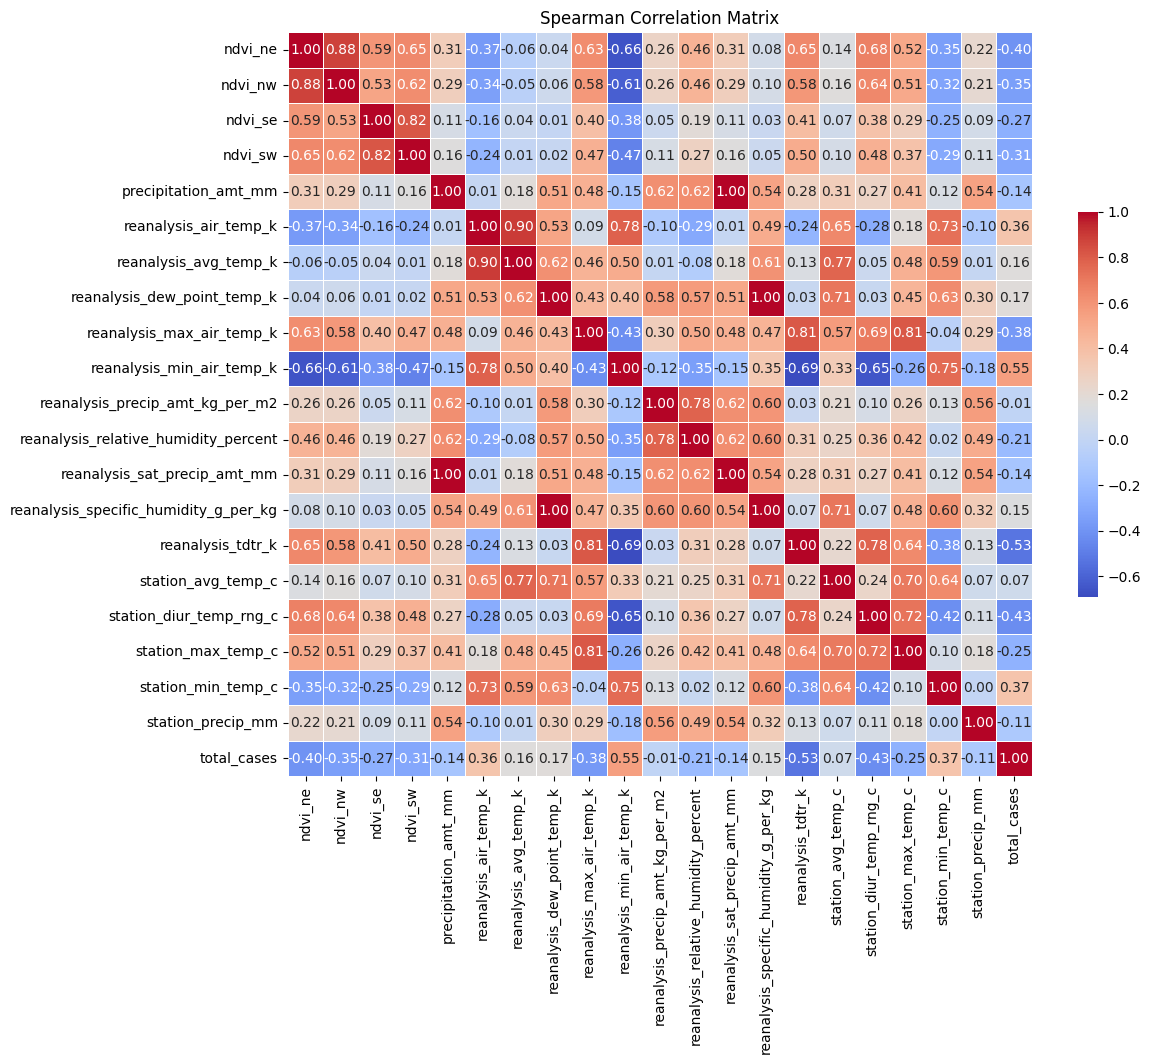

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

def load_data(features_path, labels_path):
    # Load features and labels data from CSV files
    features_data = pd.read_csv(features_path)
    labels_data = pd.read_csv(labels_path)
    return features_data, labels_data

def merge_data(features_data, labels_data):
    # Merge the datasets on city, year, and weekofyear keys
    merged_data = pd.merge(features_data, labels_data, on=['city', 'year', 'weekofyear'])
    return merged_data

def compute_spearman_correlations(merged_data):
    # Remove non-numeric and irrelevant columns
    data_for_correlation = merged_data.drop(columns=['week_start_date', 'city', 'year', 'weekofyear'])
    # Convert data to numeric, ignoring errors to skip non-convertible data
    numeric_data = data_for_correlation.apply(pd.to_numeric, errors='coerce')
    # Compute the Spearman rank correlation
    spearman_corr = numeric_data.corr(method='spearman')
    return spearman_corr

def visualize_correlation_matrix(corr_matrix):
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Spearman Correlation Matrix')
    plt.show()

# Paths to the datasets
features_path = 'dengue_features_train.csv'
labels_path = 'dengue_labels_train.csv'

# Load data
features_data, labels_data = load_data(features_path, labels_path)

# Merge data
merged_data = merge_data(features_data, labels_data)

# Compute Spearman correlations
spearman_corr_matrix = compute_spearman_correlations(merged_data)

# Visualize the Spearman correlation matrix
visualize_correlation_matrix(spearman_corr_matrix)


Epoch 1/1000
105/105 [==============================] - 2s 7ms/step - loss: 1604.8318 - val_loss: 1615.0145 - lr: 0.0050
Epoch 2/1000
105/105 [==============================] - 0s 4ms/step - loss: 1425.9371 - val_loss: 1601.6544 - lr: 0.0050
Epoch 3/1000
105/105 [==============================] - 0s 3ms/step - loss: 1410.3445 - val_loss: 1580.2526 - lr: 0.0050
Epoch 4/1000
105/105 [==============================] - 0s 3ms/step - loss: 1417.6772 - val_loss: 1546.8270 - lr: 0.0050
Epoch 5/1000
105/105 [==============================] - 0s 3ms/step - loss: 1406.9263 - val_loss: 1581.6844 - lr: 0.0050
Epoch 6/1000
105/105 [==============================] - 0s 2ms/step - loss: 1385.1825 - val_loss: 1518.6301 - lr: 0.0050
Epoch 7/1000
105/105 [==============================] - 0s 2ms/step - loss: 1388.4076 - val_loss: 1495.8779 - lr: 0.0050
Epoch 8/1000
105/105 [==============================] - 0s 2ms/step - loss: 1369.7019 - val_loss: 1485.3057 - lr: 0.0050
Epoch 9/1000
105/105 [==========

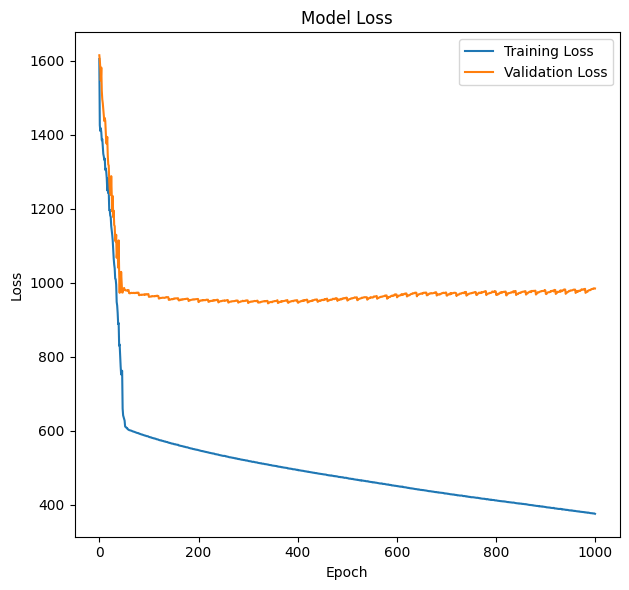

10/10 [==============================] - 0s 3ms/step


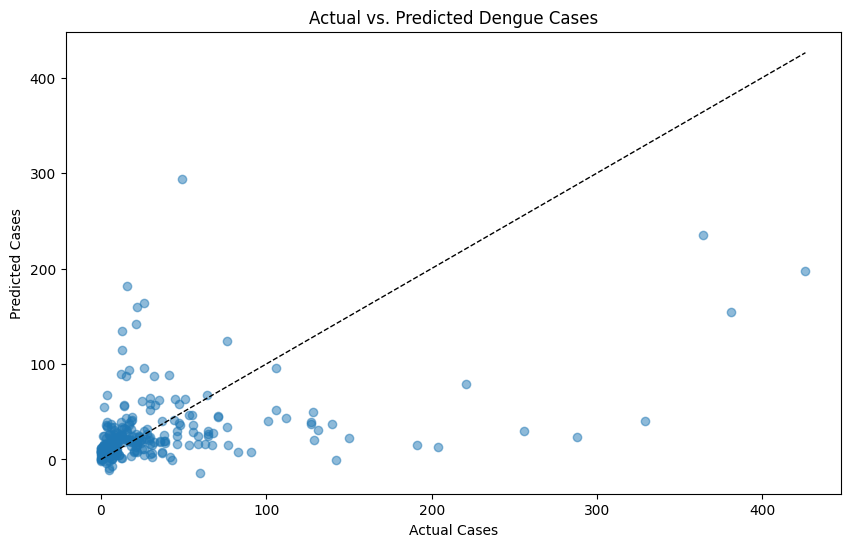

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

# Function to load and prepare the data
def load_and_prepare_data(features_path, labels_path):
    features_data = pd.read_csv(features_path)
    labels_data = pd.read_csv(labels_path)
    merged_data = pd.merge(features_data, labels_data, on=['city', 'year', 'weekofyear'])
    selected_features = merged_data.filter(regex='^(?!reanalysis).*')
    selected_features = selected_features.drop(columns=['city', 'year', 'weekofyear', 'week_start_date', 'total_cases'])
    selected_features = selected_features.fillna(selected_features.mean())
    labels = merged_data['total_cases']
    return selected_features, labels

# Function to build the neural network model
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Custom callback for shuffling data every 20 epochs
class CustomShuffleCallback(Callback):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:  # Check if it's time to shuffle (after every 20 epochs)
            print(f"Shuffling data at epoch: {epoch + 1}")
            self.model.fit(X_train_scaled, y_train, batch_size=self.batch_size, epochs=1, verbose=0, shuffle=True)  # Shuffle data

# Function to plot training and validation loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(actual, predicted):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.xlabel('Actual Cases')
    plt.ylabel('Predicted Cases')
    plt.title('Actual vs. Predicted Dengue Cases')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=1)
    plt.show()

# Paths to the datasets
features_path = 'dengue_features_train.csv'
labels_path = 'dengue_labels_train.csv'

# Load and prepare data
X, y = load_and_prepare_data(features_path, labels_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = build_model(X_train_scaled.shape[1])

# Setup ReduceLROnPlateau callback for adaptive learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Initialize the custom shuffle callback
shuffle_callback = CustomShuffleCallback(batch_size=10)

# Train the model with both callbacks
history = model.fit(X_train_scaled, y_train, validation_split=0.1, epochs=1000, batch_size=10, verbose=1, callbacks=[reduce_lr, shuffle_callback])

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss}")

# Plot training history
plot_history(history)
predictions = model.predict(X_test_scaled).flatten()
plot_actual_vs_predicted(y_test, predictions)

# Save the model to disk
model.save('dengue_model.keras')




In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('dengue_model.keras')

# Load the new dataset
df_test = pd.read_csv('dengue_features_test.csv')

# Select features and handle missing values similarly to the training data
df_test_selected = df_test.filter(regex='^(?!reanalysis).*')
df_test_selected = df_test_selected.drop(columns=['city', 'year', 'weekofyear', 'week_start_date'])
df_test_selected = df_test_selected.fillna(df_test_selected.mean())

# Load the scaler used during training and scale the new data
scaler = StandardScaler()
scaler.fit(X)  # Assuming 'X' is available in your session or load your scaler if saved
X_test_scaled = scaler.transform(df_test_selected)

# Predict using the loaded model
predictions = model.predict(X_test_scaled).flatten().astype(int)

# Prepare the submission DataFrame
submission = df_test[['city', 'year', 'weekofyear']].copy()
submission['total_cases'] = predictions

# Save the predictions to a CSV file
submission.to_csv('dengue_predicted_cases.csv', index=False)

print("Predictions saved successfully to 'dengue_predicted_cases.csv'.")


13/13 [==============================] - 0s 2ms/step
Predictions saved successfully to 'dengue_predicted_cases.csv'.
